In [8]:

import numpy as np
from utils import helpers as h
from utils import settings as s
from analysis import analysis

2024-08-05 11:50:41,839 [WARNING] utils.data_frame_processor: DataFrame is not yet initialized.
2024-08-05 11:50:41,846 [INFO] utils.data_frame_processor: DataFrame loaded and concatenated successfully from CSV.
2024-08-05 11:50:41,904 [WARNING] utils.data_frame_processor: DataFrame is not yet initialized.
2024-08-05 11:50:41,904 [INFO] utils.data_frame_processor: DataFrame loaded and concatenated successfully from CSV.


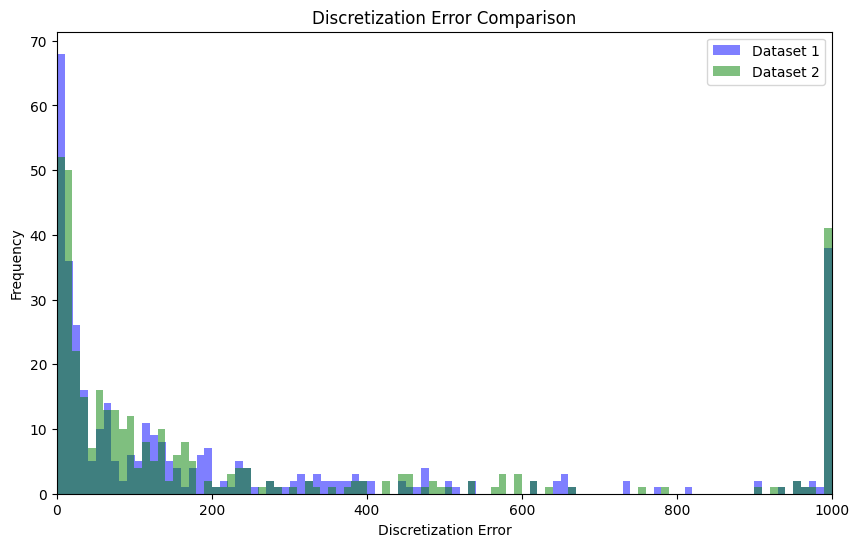

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the necessary functions and classes are imported from 'analysis' and 'h'

# First Dataset
Data1 = analysis.DataframeAnalysis()
Data1.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20240805_112505\located_activities.csv')
Data1.df['from_location'] = Data1.df['from_location'].apply(h.convert_to_shapely_point)
Data1.df['to_location'] = Data1.df['to_location'].apply(h.convert_to_shapely_point)
Data1.evaluate_distance_deviations_from_df()

# Second Dataset
Data2 = analysis.DataframeAnalysis()
Data2.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20240805_114725\hoerl_df.csv')
Data2.df['from_location'] = Data2.df['from_location'].apply(h.convert_to_shapely_point)
Data2.df['to_location'] = Data2.df['to_location'].apply(h.convert_to_shapely_point)
Data2.evaluate_distance_deviations_from_df()

# Ensure the maximum value is limited to 1000
Data1.df['discretization_error'] = Data1.df['discretization_error'].clip(upper=1000)
Data2.df['discretization_error'] = Data2.df['discretization_error'].clip(upper=1000)

# Plotting in the same plot
plt.figure(figsize=(10, 6))

# Plot histogram for Dataset 1
Data1.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='blue', label='Dataset 1')

# Plot histogram for Dataset 2
Data2.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='green', label='Dataset 2')

# Adding title and labels
plt.title('Discretization Error Comparison')
plt.xlabel('Discretization Error')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.legend()

plt.show()


mean, median, plot deviation dist, the same per chain, -- capacity matching??

In [11]:
Data1.df['discretization_error'].describe()

count     363.000000
mean      242.170627
std       329.791917
min         0.291530
25%        16.552275
50%        89.059436
75%       320.935116
max      1000.000000
Name: discretization_error, dtype: float64

In [12]:
Data2.df['discretization_error'].describe()


count     363.000000
mean      233.431045
std       331.228807
min         0.056863
25%        18.321902
50%        74.755645
75%       247.041961
max      1000.000000
Name: discretization_error, dtype: float64